For detectron2 implementation https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

Use coco_validator.py to test if dataset is in coco format (should be if you used genData.ipynb)

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "./dataInfo.json", "./trainData/")
register_coco_instances("my_dataset_val", {}, "./valInfo.json", "./valData/")

In [3]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [5]:
os.environ["LRU_CACHE_CAPACITY"] = '1'   # solves memory leak problem (dont ask why)

cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
num_gpu = 1
bs = (num_gpu * 2)
cfg.SOLVER.BASE_LR = 0.00025  # pick a good Learning rate (0.00025 should work I think)
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only one class for now (tracks)

In [6]:
# it takes like 4 minitues for it to start training, if you have shitty cpu

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/14 17:53:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

2023-11-14 17:53:11.805095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 17:53:13.814083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4,

[11/14 17:53:17 d2.engine.train_loop]: Starting training from iteration 0


/home/wallachmayas/bubbleID/.myenv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/14 17:56:14 d2.utils.events]:  eta: 0:10:46  iter: 19  total_loss: 1.677  loss_cls: 0.7421  loss_box_reg: 0.7113  loss_rpn_cls: 0.1372  loss_rpn_loc: 0.02058  time: 8.2748  data_time: 0.0105  lr: 4.7703e-05  
[11/14 17:59:20 d2.utils.events]:  eta: 0:08:36  iter: 39  total_loss: 1.607  loss_cls: 0.513  loss_box_reg: 0.8952  loss_rpn_cls: 0.0932  loss_rpn_loc: 0.03181  time: 8.7977  data_time: 0.0038  lr: 9.7653e-05  
[11/14 18:02:21 d2.utils.events]:  eta: 0:05:49  iter: 59  total_loss: 1.306  loss_cls: 0.4332  loss_box_reg: 0.8686  loss_rpn_cls: 0.04239  loss_rpn_loc: 0.02065  time: 8.8853  data_time: 0.0047  lr: 0.0001476  
[11/14 18:05:16 d2.utils.events]:  eta: 0:02:54  iter: 79  total_loss: 1.368  loss_cls: 0.4176  loss_box_reg: 0.9021  loss_rpn_cls: 0.02487  loss_rpn_loc: 0.02756  time: 8.8592  data_time: 0.0034  lr: 0.00019755  
[11/14 18:08:18 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 1.38  loss_cls: 0.3819  loss_box_reg: 0.94  loss_rpn_cls: 0.01834  loss_rpn_l

Validation

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val",)
predictor = DefaultPredictor(cfg)

[11/14 18:08:31 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

[11/14 18:08:32 d2.data.datasets.coco]: Loaded 50 images in COCO format from ./valInfo.json


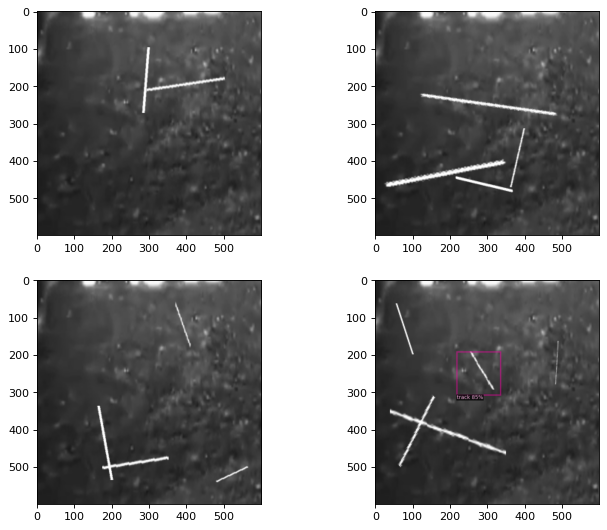

In [8]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
dataset_dicts = DatasetCatalog.get("my_dataset_val")
metadata = MetadataCatalog.get("my_dataset_train")
plt.figure(figsize=(10, 8), dpi=80)

for i in range(4):
    for d in random.sample(dataset_dicts, 1):   # this is one because there is only one class right now
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=2, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.subplot(2,2,i+1)
        plt.imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)